# Análise de cluster das linhas do transporte público.

O objetivo deste trabalho é realizar uma análise das linhas afim de obter uma classificação de acordo com um critério matemático. Este processo é importante pois podemos definir linhas que possuem comportamentos ou frequências de passageiros parecidos indicando direcionamentos e mudanças para linhas especificas, buscando uma maior eficiência do sistema. 

Iremos restringir a análise para dias úteis, pois são os dias que possuem uma maior exigência do sistema e como iremos utilizar as médias de passageiros por viagem, dias de final de semana, se incluídos, iriam influenciar nas medidas obtidas obtidas agindo como valores extremos.

Para realizar a análise de cluster utilizamos a média diária por tipo de passageiro e obtemos a tabela a seguir. O próximo passo é realizar o agrupamento.

In [57]:
import pandas as pd
import numpy as np

from function_files import files #  funções criada para carregar os arquivos
from function_files import pas


import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

# configuração dos gráficos 
from matplotlib import rc
# estilo dos gráficos #https://matplotlib.org/stable/gallery/style_sheets/style_sheets_reference.html
plt.style.use('Solarize_Light2')
%config InlineBackend.figure_format = 'retina'  # formato das imagens
rc('font', **{"family":"sans-serif","sans-serif":["DejaVu Sans"], "size":10})

rc('mathtext', **{"default":"regular"})

import warnings
warnings.filterwarnings("ignore")

In [81]:
df = files(22)
freq_routes = df['Nome Linha'].value_counts()
df = df[~df['Nome Linha'].isin(freq_routes[freq_routes < 500].index)] # filtrando linhas com poucas viagens - pouco frequentes
diario = pas(df)

def routes():
    df['Data Coleta'] = pd.to_datetime(df['Data Coleta'], format='%d/%m/%Y')
    df['dia_semana'] = df['Data Coleta'].dt.dayofweek
    routes = df.query('dia_semana < 5').groupby("Nome Linha")[['Gratuidade', 'VT', 'VT Integração', 'Estudantes', 'EStudantes Integração', 'Inteiras']].agg("mean").round(2)
    routes = routes.drop(routes[(routes.Inteiras<5)].index)
    return(routes)


routes = routes()
routes

,Gratuidade,VT,VT Integração,Estudantes,EStudantes Integração,Inteiras
Nome Linha,,,,,,
ALTO DA RESSUREICAO PONTE WALL FERRAZ,20.32,20.47,2.83,16.77,2.42,26.85
ALTO DA RESSUREICAO/BARAO,11.39,20.81,1.65,17.77,1.70,21.05
ANITA FERRAZ VIA CONJUNTO,7.89,21.50,3.17,17.88,2.25,35.32
BELAVISTA VIA S.MARIA (CIRCULAR),6.76,8.75,0.00,9.62,0.30,44.61
BOQUINHA,4.70,13.35,0.00,9.97,0.35,27.12
...,...,...,...,...,...,...
VALE DO GAVIAO / PLANALTO URUGUAI,10.10,25.84,4.21,30.14,4.94,44.81
VILA BANDEIRANTE DOM SEVERINO,6.33,16.85,2.88,18.57,2.70,26.22
VILA BANDEIRANTE-PLANALTO ININGA FREI SERAFIM,9.21,20.66,3.50,20.26,2.81,33.62


Um primeiro problema que precisa ser resolvido é definir quantos grupos serão construídos para a divisão das linhas de ônibus. Os gráficos abaixo fazem uma relação entre as distâncias entre os elementos entre si e os elementos agrupados.

O primeiro método é o Elbow, onde realizamos o método k-means para um número k de grupos e medimos a soma dos erros quadrados entre os centróides e os elementos. Quando vemos que a separação das linha não é significativa, pode-se indicar o número de grupos.

Identificamos que o número de grupos eficiente é 3.

<Figure size 432x288 with 0 Axes>

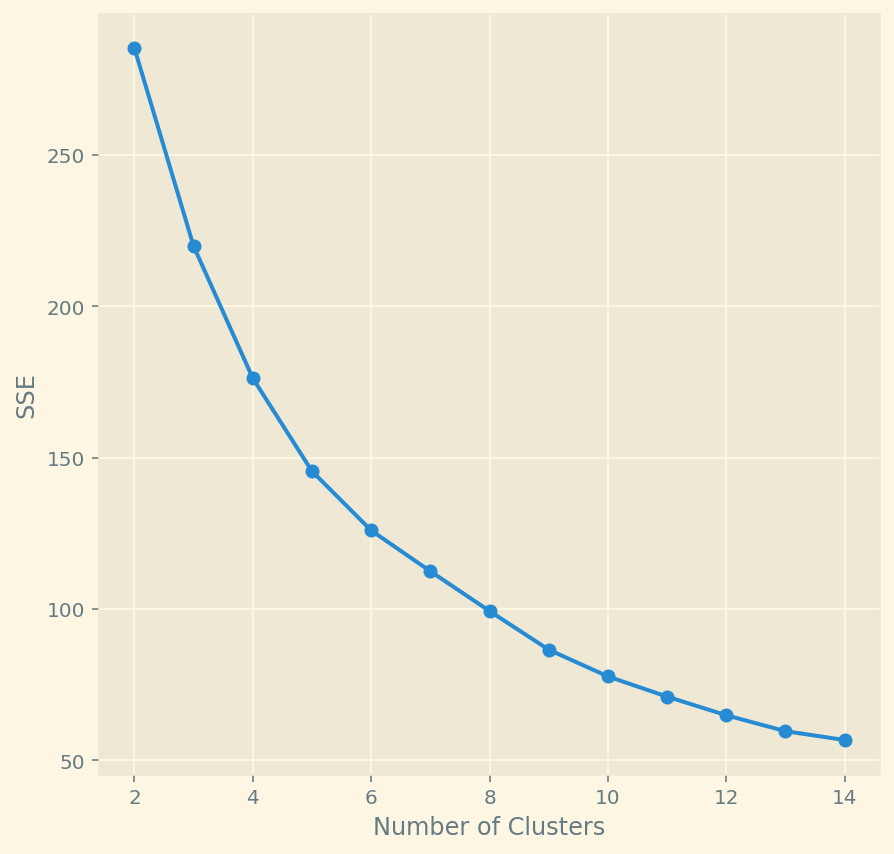

In [82]:
from sklearn.cluster import KMeans

clusters_range = [2,3,4,5,6,7,8,9,10,11,12,13,14]
inertias = []

# normalizando as colunhas de forma mais tradicional
routes_norm = (routes - routes.mean())/routes.std()

for c in clusters_range:
    kmeans = KMeans(init= 'k-means++', n_clusters= c, n_init=100, random_state=4).fit(routes_norm)
    inertias.append(kmeans.inertia_)

def cluster_():
    plt.figure()
    plt.figure(figsize=(7,7))
    plt.plot(clusters_range, inertias, marker = 'o')
    plt.xlabel("Number of Clusters")
    plt.ylabel("SSE")
    plt.show()

cluster_()

Esse primeiro método, apesar de uso bem comum para a classificação, pode ser um pouco confuso. Para auxiliar, utilizamos o heatmeap a seguir, que indica de forma gráfica e númerica o número de grupos. 

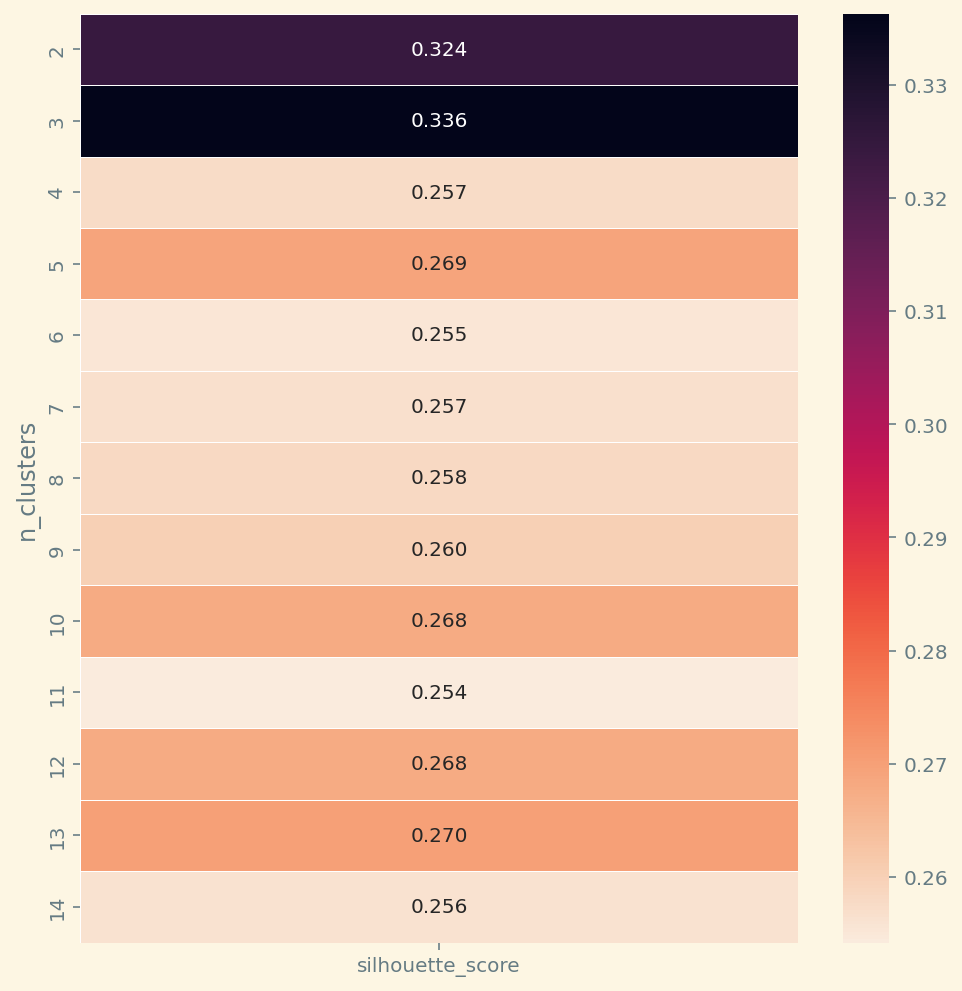

In [83]:
from pandas import pivot
from sklearn.metrics import silhouette_samples, silhouette_score

def heat_cluster():
    clusters_range = range(2,15)
    results = []

    for c in clusters_range:
        clusterer = KMeans(init= "k-means++", n_clusters=c, n_init = 100, random_state=4)
        cluster_labels = clusterer.fit_predict(routes_norm)
        silhouette_avg = silhouette_score(routes_norm, cluster_labels)
        results.append([c,silhouette_avg])

    result = pd.DataFrame(results, columns=["n_clusters", "silhouette_score"])
    pivot_km = pd.pivot_table(result, index="n_clusters", values = "silhouette_score")

    plt.figure(figsize=(7,7))
    sns.heatmap(pivot_km, annot = True, linewidths=.5, fmt = '.3f', cmap = sns.cm.rocket_r)
    plt.tight_layout()

heat_cluster() 

A divisão que melhor agrupa as linhas é na quantidade de 3. Iremos análisar essa diferença e realizar alguns testes para confirmar a divisão.
Para entender melhor a divisão, temos a quantidade de elementos por grupo.

In [84]:
kmeans_sel = KMeans(init= "k-means++", n_clusters=3, n_init = 100, random_state=4).fit(routes_norm)   
routes["Cluster"] = kmeans_sel.labels_
routes['Cluster'].value_counts().to_frame()

,Cluster
1,38
0,36
2,1


Analisando graficamente a divisão das linhas, através de componentes principais, percebemos que a variação das linhas ocorre devido a diferença do número depassageiros. Destacando-se o único elemento do grupo 2. 

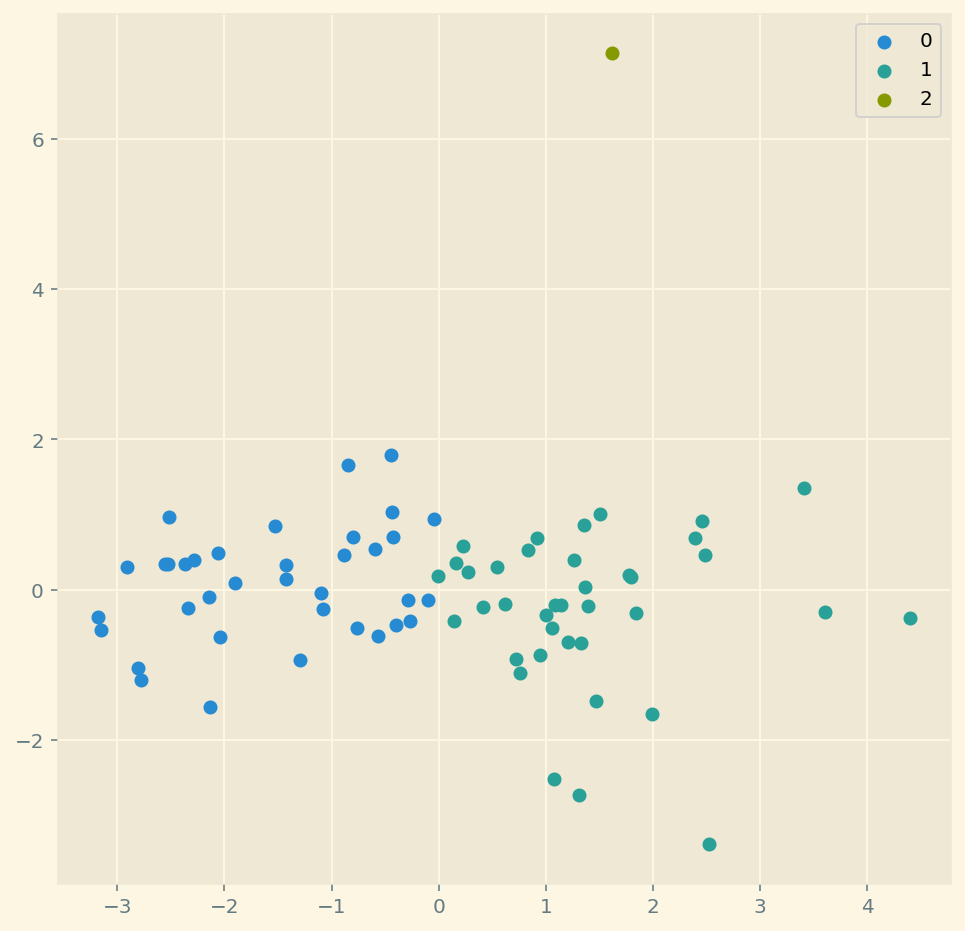

In [85]:
# Criando modelo com três grupos
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA

kmeans_sel = KMeans(init= "k-means++", n_clusters=3, n_init = 100, random_state=4).fit(routes_norm)

# Transform the df in a matrix with 2 columns
data = load_digits().data
pca = PCA(2)
routes_pca = pca.fit_transform(routes_norm)
    

def graphic_cluster():
    labels = kmeans_sel.labels_
    u_labels = np.unique(labels)
    plt.figure(figsize=(8,8))
    for i in u_labels:
        plt.scatter(routes_pca[labels == i , 0] , routes_pca[labels == i , 1] , label = i)
        plt.legend(loc='upper right')
    plt.show()

graphic_cluster()

## Método Análise Discriminante 

Após a classificação feita, iremos testar a classificação utlizando o método de Análise Discriminante, que utiliza a função discriminante de Fisher a construção da divisão.

Índice de semelhança: 0.902


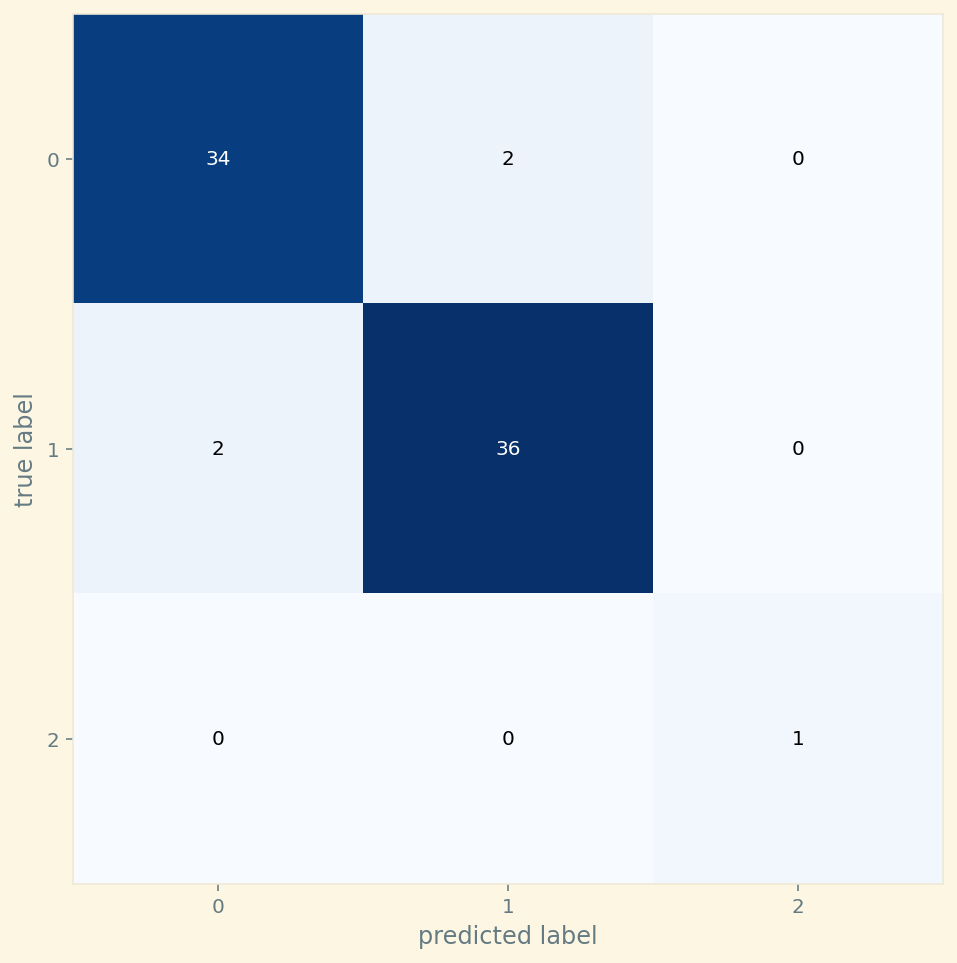

In [86]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

X = routes.iloc[:, 1:6].values
y = routes['Cluster']
model_discriminant = LinearDiscriminantAnalysis().fit(X,y)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=4)
scores = cross_val_score(model_discriminant, X, y, scoring = 'accuracy', cv = cv, n_jobs = -1)
print(f"Índice de semelhança: {np.mean(scores).round(3)}")
y_pred = model_discriminant.predict(X)


def disc_analyses():
    matriz2 = confusion_matrix(y_true=y, y_pred=y_pred)
    fig, ax = plot_confusion_matrix(conf_mat = matriz2)
    fig.set_size_inches(8,8)
    plt.show()

disc_analyses()

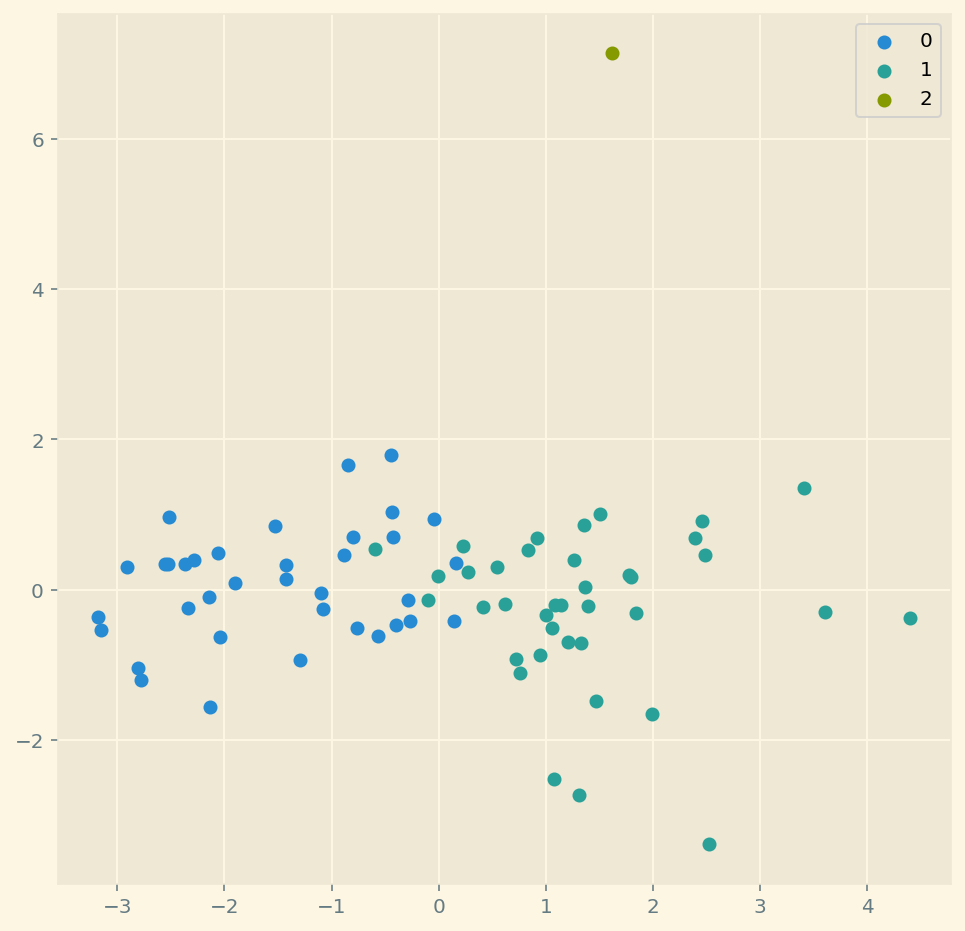

In [87]:
def graphic_disc():
    labels_disc = y_pred
    u_labels_disc = np.unique(labels_disc)
    plt.figure(figsize=(8,8))
    for i in u_labels_disc:
        plt.scatter(routes_pca[labels_disc == i , 0] , routes_pca[labels_disc == i , 1] , label = i)
    
    plt.legend(loc='upper right')
    plt.show()

graphic_disc()

A análise de discriminante conseguiu um resultado de 90% similar ao método de K-means, indicando um modelo eficiciente. Analisando  o gráfico, temos que o conflito está na região de intersecção dos grupos, onde temos valores muito próximos. 

## Análise do divisão por grupo

Com a divisão dos grupos, uma segunda etapa é realizar uma interpretação da classificação determinada. 

O método escolhido consiste numa análise na média de passageiros por grupo e identificar as diferenças pelos valores obtidos. A tabela abaixo nos informa as médias por passageiro.

In [88]:
routes.groupby(['Cluster']).mean().round(1)

,Gratuidade,VT,VT Integração,Estudantes,EStudantes Integração,Inteiras
Cluster,,,,,,
0,7.9,15.4,1.7,15.4,1.6,20.0
1,12.3,24.3,2.6,22.6,2.4,32.4
2,5.0,9.2,4.2,35.5,13.2,12.7


A partir da análise, podemos entender a classificação dessa forma:

- Grupo 0: linhas de menor demanda
- Grupo 1: linhas com maior demanda
- Grupo 2: linhas com demanda escolar.

## Linhas por grupo

### Menor Demanda

In [89]:
routes['Cluster'] = routes['Cluster'].map({0:'Menor Demanda', 1:'Maior Demanda', 2:'Demanda Estudantil'})
routes.loc[(routes['Cluster'] == 'Menor Demanda')]


,Gratuidade,VT,VT Integração,Estudantes,EStudantes Integração,Inteiras,Cluster
Nome Linha,,,,,,,
ALTO DA RESSUREICAO/BARAO,11.39,20.81,1.65,17.77,1.70,21.05,Menor Demanda
BELAVISTA VIA S.MARIA (CIRCULAR),6.76,8.75,0.00,9.62,0.30,44.61,Menor Demanda
BOQUINHA,4.70,13.35,0.00,9.97,0.35,27.12,Menor Demanda
BUENOS AIRES AEROPORTO,6.40,13.54,1.70,11.79,1.19,12.81,Menor Demanda
HD-PARQUE JUREMA-SHOPPING,5.52,13.94,1.43,13.61,1.63,16.40,Menor Demanda
HD-SACY SHOPPING VIA MIGUEL ROSA,8.54,14.53,3.61,14.55,3.23,18.02,Menor Demanda
HD-SANTA MARIA-VASSOURAS PQ. ALVORADA,13.44,16.91,2.00,14.71,1.31,20.43,Menor Demanda
HD-SAO PAULO SHOPPING VIA SAO JOAO,6.60,16.49,1.42,13.80,1.53,17.32,Menor Demanda
HD-T. OS SANTOS-FREI DAMIAO-JOAO XXIII,6.31,19.49,3.09,14.07,1.94,23.35,Menor Demanda


### Linhas de maior demanda

In [90]:
routes.loc[(routes['Cluster'] == 'Maior Demanda')]

,Gratuidade,VT,VT Integração,Estudantes,EStudantes Integração,Inteiras,Cluster
Nome Linha,,,,,,,
ALTO DA RESSUREICAO PONTE WALL FERRAZ,20.32,20.47,2.83,16.77,2.42,26.85,Maior Demanda
ANITA FERRAZ VIA CONJUNTO,7.89,21.50,3.17,17.88,2.25,35.32,Maior Demanda
CERAMICA CIL BARAO,8.64,21.20,1.65,21.29,1.48,43.35,Maior Demanda
CERAMICA CIL MIGUEL ROSA,8.24,24.25,2.84,25.75,2.65,31.59,Maior Demanda
DIAMETRAL MOCAMBINHO-PORTO ALEGRE,15.81,27.71,0.00,23.57,0.78,36.62,Maior Demanda
DIAMETRAL MOCAMBINHO-PROMORAR,18.17,36.11,0.00,26.47,0.68,36.77,Maior Demanda
DIAMETRAL POTY VELHO-PL. BELA VISTA,16.12,28.31,0.00,24.70,0.79,28.31,Maior Demanda
HD-IRMA DULCE-ANGELIM MIGUEL ROSA,16.85,28.73,3.54,28.01,3.46,41.65,Maior Demanda
HD-IRMA DULCE-BARAO,15.83,25.64,1.60,24.18,1.67,40.31,Maior Demanda


### Linhas de demanda escolar

In [91]:
routes.loc[(routes['Cluster'] == 'Demanda Estudantil')]


,Gratuidade,VT,VT Integração,Estudantes,EStudantes Integração,Inteiras,Cluster
Nome Linha,,,,,,,
UNIVERSIDADE,5.0,9.18,4.19,35.51,13.21,12.67,Demanda Estudantil


Com resultados obtidos, o orgão ou as empresesas podem realizar uma reestruturação das linhas para obter linhas com uma maior rentabilidade 